# 3_Model_Training.ipynb


In [31]:
# ========================================================
# 1. Imports and Setup
# ========================================================
import numpy as np
import json
import matplotlib.pyplot as plt
import os

# TensorFlow/Keras Imports
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import (
    Embedding, LSTM, Dense, Bidirectional, Dropout, Conv1D, GlobalMaxPooling1D
)
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping

# Set random seeds for reproducibility (optional)
tf.random.set_seed(120)
np.random.seed(120)

# Ensure directory for saving models exists
save_dir = "../../models/sentiment_analysis"
os.makedirs(save_dir, exist_ok=True)

print("All required libraries imported and environment set up.")


All required libraries imported and environment set up.


## 2. Load and Prepare Data



In [32]:
# Load the data from .npy files
base_data_dir = "../../data/sentiment_analysis/processed/"
X_train = np.load(base_data_dir + 'X_train.npy', allow_pickle=True)
y_train = np.load(base_data_dir + 'y_train.npy', allow_pickle=True)
X_val   = np.load(base_data_dir + 'X_val.npy', allow_pickle=True)
y_val   = np.load(base_data_dir + 'y_val.npy', allow_pickle=True)

print(f"X_train shape: {X_train.shape}")
print(f"y_train shape: {y_train.shape}")
print(f"X_val shape:   {X_val.shape}")
print(f"y_val shape:   {y_val.shape}")

# Load tokenizer to fetch 'vocab_size' or to transform new data if needed
with open(base_data_dir + 'tokenizer.json', 'r') as f:
    tokenizer_data = json.load(f)
    tokenizer = keras.preprocessing.text.tokenizer_from_json(json.dumps(tokenizer_data))

# Optionally, get vocab_size directly from tokenizer
vocab_size = len(tokenizer.word_index) + 1
print(f"Vocabulary size: {vocab_size}")

# Convert labels (y) to one-hot encoded format if they aren't already
# (e.g., labels: 0 = Bearish, 1 = Bullish, 2 = Neutral)
num_classes = 3

if len(y_train.shape) == 1:
    y_train = keras.utils.to_categorical(y_train, num_classes=num_classes)
if len(y_val.shape) == 1:
    y_val = keras.utils.to_categorical(y_val, num_classes=num_classes)

print(f"y_train one-hot shape: {y_train.shape}")
print(f"y_val one-hot shape:   {y_val.shape}")


X_train shape: (9544, 100)
y_train shape: (9544,)
X_val shape:   (1193, 100)
y_val shape:   (1193,)
Vocabulary size: 18031
y_train one-hot shape: (9544, 3)
y_val one-hot shape:   (1193, 3)


In [33]:
embedding_dim = 100
max_length = X_train.shape[1]  # Assumes X_train is already padded to a fixed length

## 3. Model 1 Architecture (CNN-Based Model)

This model uses:

### Embedding Layer
- Learns dense vector representations of words (word embeddings)
- Converts sequences of words (represented as integers) into a meaningful dense representation

### Conv1D Layer
- Extracts local patterns and features from the sequence using a sliding window approach
- Detects patterns such as n-grams (e.g., "market is bullish") without requiring sequential dependencies

### GlobalMaxPooling1D Layer
- Reduces the dimensionality of the convolution output
- Captures the most significant feature for each filter, ensuring fixed-length output regardless of input sequence length

### Dense Layer
- Adds a fully connected layer with 64 units to learn non-linear combinations of the extracted features

### Dropout Layer
- Regularizes the model to prevent overfitting by randomly dropping units during training

### Output Layer
- Outputs 3 units for Bearish/Bullish/Neutral classification
- Uses a softmax activation function to produce probabilities for each class

In [34]:
# Define CNN model
model1 = Sequential([
    Embedding(input_dim=vocab_size, output_dim=embedding_dim, input_length=max_length),
    Conv1D(filters=128, kernel_size=5, activation='relu'),  # Convolution layer
    GlobalMaxPooling1D(),  # Reduce dimensionality
    Dense(64, activation='relu'),  # Fully connected layer
    Dropout(0.5),  # Regularization
    Dense(num_classes, activation='softmax')  # Output layer
], name="CNN_Text_Model")

# Compile the model
model1.compile(
    optimizer=Adam(learning_rate=0.001),  # Optimizer with a specified learning rate
    loss='categorical_crossentropy',     # Loss function for multi-class classification
    metrics=['accuracy']                 # Metric to monitor
)

# Print model summary
model1.summary()

c:\Users\saif\source\ai_project\venv\Lib\site-packages\keras\src\layers\core\embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "CNN_Text_Model"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_3 (Embedding)         │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_1 (Conv1D)               │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_max_pooling1d_1          │ ?                      │             0 │
│ (GlobalMaxPooling1D)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

## 4. Model 2 Architecture (Bidirectional LSTM)
This model uses:
- **Embedding Layer**: word embeddings.
- **Bidirectional LSTM**: captures both forward and backward dependencies.
- **Dense Layers**: extra layers to deepen the network.


In [35]:
model2 = Sequential([
    Embedding(input_dim=vocab_size, output_dim=embedding_dim, input_length=max_length),
    Bidirectional(LSTM(64, return_sequences=True)),
    Dropout(0.2),
    Bidirectional(LSTM(32)),
    Dense(64, activation='relu'),
    Dropout(0.2),
    Dense(num_classes, activation='softmax')
], name="Bidirectional_LSTM_Model")

model2.compile(
    optimizer=Adam(),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

model2.summary()


Model: "Bidirectional_LSTM_Model"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_4 (Embedding)         │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_2 (Bidirectional) │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_3 (Bidirectional) │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

## 5. Model Training and Early Stopping
We will train each model up to 20 epochs, using a batch size of 64, and apply early stopping with a patience of 6.


In [44]:
# Early stopping callback
early_stop = EarlyStopping(
    monitor='val_loss',
    verbose=1,
    patience=6,
    restore_best_weights=True,
    mode='auto',
    start_from_epoch=3
)

# Training hyperparameters
epochs = 20
batch_size = 64


In [45]:
# Train Model 1
history1 = model1.fit(
    X_train,
    y_train,
    validation_data=(X_val, y_val),
    epochs=epochs,
    batch_size=batch_size,
    callbacks=[early_stop],
    verbose=1
)

Epoch 1/20
150/150 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.9774 - loss: 0.0807 - val_accuracy: 0.7821 - val_loss: 1.1013
Epoch 2/20
150/150 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.9857 - loss: 0.0489 - val_accuracy: 0.7812 - val_loss: 1.1543
Epoch 3/20
150/150 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.9934 - loss: 0.0284 - val_accuracy: 0.7837 - val_loss: 1.2033
Epoch 4/20
150/150 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.9941 - loss: 0.0233 - val_accuracy: 0.7770 - val_loss: 1.2575
Epoch 5/20
150/150 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.9951 - loss: 0.0182 - val_accuracy: 0.7812 - val_loss: 1.3861
Epoch 6/20
150/150 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.9965 - loss: 0.0140 - val_accuracy: 0.7728 - val_loss: 1.4029
Epoch 7/20
150/150 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.9969 - loss: 0.0119 - val_accuracy: 0.7812 - val_loss: 1.4938
Epoch 8/20
150/150 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.9958 - loss: 0.0130 - val_accuracy: 

In [46]:

# Train Model 2
history2 = model2.fit(
    X_train,
    y_train,
    validation_data=(X_val, y_val),
    epochs=epochs,
    batch_size=batch_size,
    callbacks=[early_stop],
    verbose=1
)

Epoch 1/20
150/150 ━━━━━━━━━━━━━━━━━━━━ 10s 65ms/step - accuracy: 0.9701 - loss: 0.1045 - val_accuracy: 0.7628 - val_loss: 0.9717
Epoch 2/20
150/150 ━━━━━━━━━━━━━━━━━━━━ 10s 65ms/step - accuracy: 0.9730 - loss: 0.0908 - val_accuracy: 0.7645 - val_loss: 1.1727
Epoch 3/20
150/150 ━━━━━━━━━━━━━━━━━━━━ 16s 106ms/step - accuracy: 0.9799 - loss: 0.0639 - val_accuracy: 0.7519 - val_loss: 1.2416
Epoch 4/20
150/150 ━━━━━━━━━━━━━━━━━━━━ 15s 100ms/step - accuracy: 0.9831 - loss: 0.0584 - val_accuracy: 0.7586 - val_loss: 1.2767
Epoch 5/20
150/150 ━━━━━━━━━━━━━━━━━━━━ 10s 64ms/step - accuracy: 0.9889 - loss: 0.0412 - val_accuracy: 0.7527 - val_loss: 1.3228
Epoch 6/20
150/150 ━━━━━━━━━━━━━━━━━━━━ 10s 64ms/step - accuracy: 0.9890 - loss: 0.0368 - val_accuracy: 0.7552 - val_loss: 1.4018
Epoch 7/20
150/150 ━━━━━━━━━━━━━━━━━━━━ 9s 62ms/step - accuracy: 0.9890 - loss: 0.0332 - val_accuracy: 0.7410 - val_loss: 1.4811
Epoch 8/20
150/150 ━━━━━━━━━━━━━━━━━━━━ 9s 60ms/step - accuracy: 0.9912 - loss: 0.0279 - 

## 6. Evaluation & Visualization
Let's visualize accuracy and loss curves for both training and validation sets, for each model.


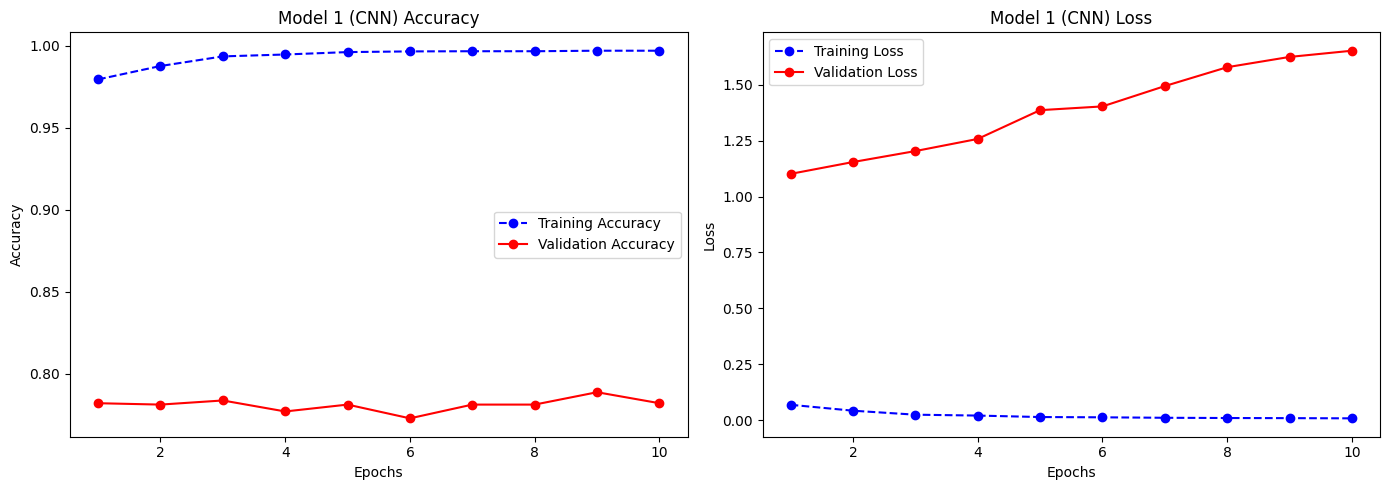

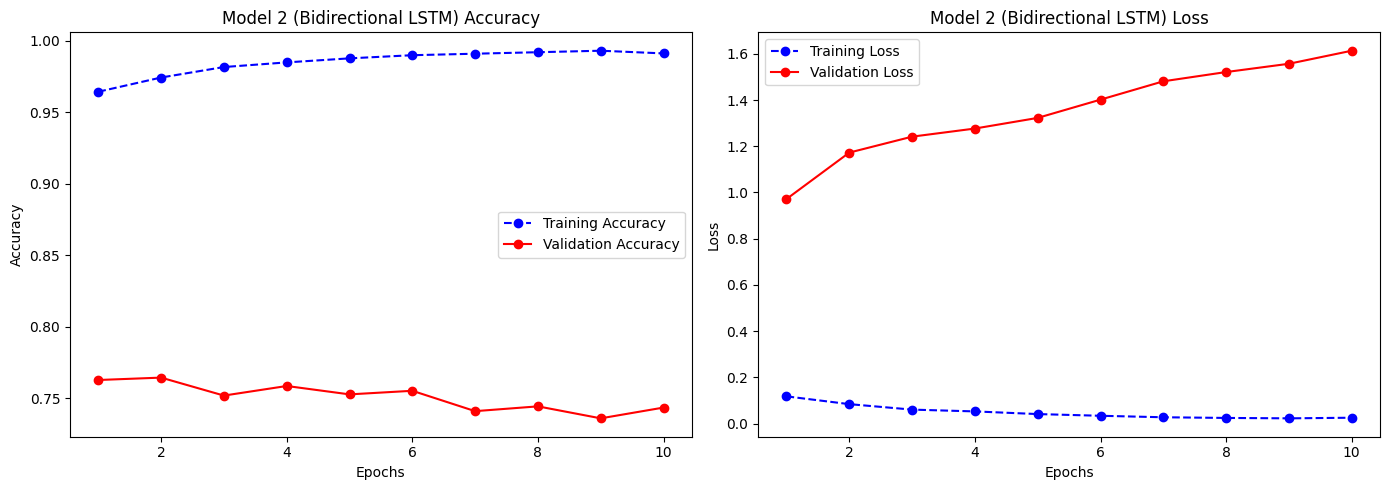

In [48]:
def plot_history(history, model_name):
    """Utility function to plot training history."""
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']

    epochs_range = range(1, len(acc) + 1)

    plt.figure(figsize=(14, 5))
    
    # Accuracy plot
    plt.subplot(1, 2, 1)
    plt.plot(epochs_range, acc, 'bo--', label='Training Accuracy')
    plt.plot(epochs_range, val_acc, 'ro-', label='Validation Accuracy')
    plt.title(f'{model_name} Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    # Loss plot
    plt.subplot(1, 2, 2)
    plt.plot(epochs_range, loss, 'bo--', label='Training Loss')
    plt.plot(epochs_range, val_loss, 'ro-', label='Validation Loss')
    plt.title(f'{model_name} Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    plt.tight_layout()
    plt.show()

# Plot for Model 1
plot_history(history1, "Model 1 (CNN)")

# Plot for Model 2
plot_history(history2, "Model 2 (Bidirectional LSTM)")


## 7. Saving Models and Histories
Finally, we will save the trained models in the `models/sentiment_analysis/` directory and also save the training history for later analysis.


In [49]:
# Save models
model1.save(os.path.join(save_dir, "model1_cnn.keras"))
model2.save(os.path.join(save_dir, "model2_bi_lstm.keras"))

print("Models saved to 'models/sentiment_analysis/'")

# Save histories as numpy files 
np.save(os.path.join(save_dir, "history1.npy"), history1.history)
np.save(os.path.join(save_dir, "history2.npy"), history2.history)

print("Training histories saved.")


Models saved to 'models/sentiment_analysis/'
Training histories saved.


# Conclusion

We have:
1. Loaded and preprocessed the data (including label one-hot encoding).
2. Built and trained two models:
   - **Model 1**: A **CNN** model.
   - **Model 2**: A **Bidirectional LSTM** model with additional Dense layers.
3. Configured early stopping, saving only the best weights (based on validation loss).
4. Visualized the training and validation accuracy/loss.
5. Saved the models and training metadata for future use.
